<a href="https://colab.research.google.com/github/AoShuang92/Transformer_simple_example/blob/master/Transformer_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

torch.Size([5, 7])
Epoch: 0001 cost = 1.927750
torch.Size([5, 7])
Epoch: 0002 cost = 0.271256
torch.Size([5, 7])
Epoch: 0003 cost = 0.095381
torch.Size([5, 7])
Epoch: 0004 cost = 0.012578
torch.Size([5, 7])
Epoch: 0005 cost = 0.015600
torch.Size([5, 7])
Epoch: 0006 cost = 0.029517
torch.Size([5, 7])
Epoch: 0007 cost = 0.010804
torch.Size([5, 7])
Epoch: 0008 cost = 0.008447
torch.Size([5, 7])
Epoch: 0009 cost = 0.001204
torch.Size([5, 7])
Epoch: 0010 cost = 0.000691
torch.Size([5, 7])
Epoch: 0011 cost = 0.008789
torch.Size([5, 7])
Epoch: 0012 cost = 0.001940
torch.Size([5, 7])
Epoch: 0013 cost = 0.000990
torch.Size([5, 7])
Epoch: 0014 cost = 0.000338
torch.Size([5, 7])
Epoch: 0015 cost = 0.001743
torch.Size([5, 7])
Epoch: 0016 cost = 0.000110
torch.Size([5, 7])
Epoch: 0017 cost = 0.000216
torch.Size([5, 7])
Epoch: 0018 cost = 0.000091
torch.Size([5, 7])
Epoch: 0019 cost = 0.000079
torch.Size([5, 7])
Epoch: 0020 cost = 0.000238
torch.Size([5, 7])
ich mochte ein bier P -> ['i', 'want', 'a

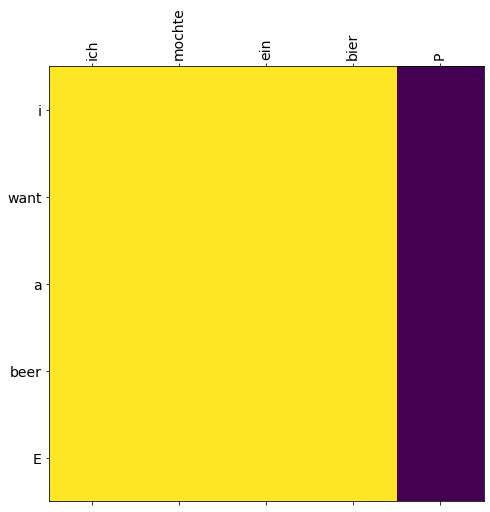

first head of last state dec_self_attns


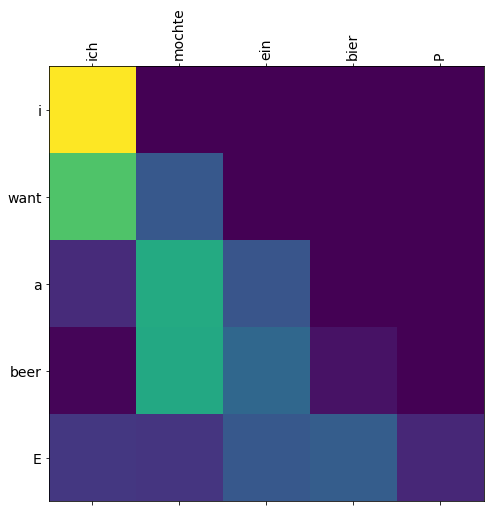

first head of last state dec_enc_attns


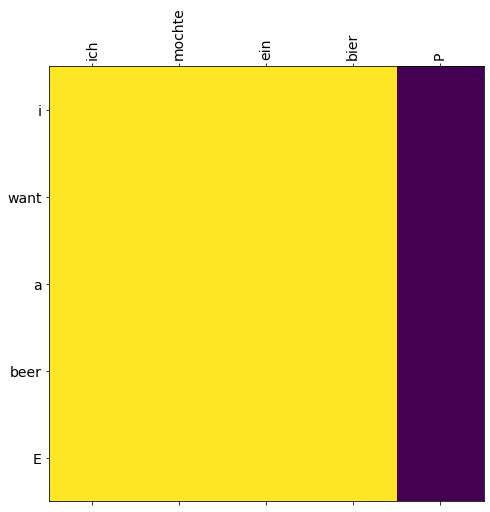

In [ ]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
  Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
              https://github.com/JayParks/transformer
'''
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# Transformer Parameters
# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)} #number_dict {0: 'P', 1: 'i', 2: 'want', 3: 'a', 4: 'beer', 5: 'S', 6: 'E'}

tgt_vocab_size = len(tgt_vocab)

src_len = 5
tgt_len = 5

d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    #print("input_batch",input_batch) #[[1, 2, 3, 4, 0]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    #print("output_batch",output_batch) #[[5, 1, 2, 3, 4]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    #print("target_batch",target_batch) # [[1, 2, 3, 4, 6]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        #print('hid_idx',hid_idx) #hid_idx is int
        #print("return1", position / np.power(10000, 2 * (hid_idx // 2) / d_model))
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    #print("batch_size",batch_size) #1
    #print("len_q",len_q) # 5
    batch_size, len_k = seq_k.size()
    #print("len_k",len_k) #5
    # eq(zero) is PAD token
    #only eq(zero) equal=0 is true, others all false
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    #print("pad_attn_mask",pad_attn_mask.size()) #[1, 1, 5]
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    #print("attn_shape",attn_shape) #[1, 5, 5]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    #print("subsequent_mask",subsequent_mask) # to set the upper triangle value as 1, other parts as 0
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    #print("subsequent_mask",subsequent_mask.size()) #([1, 5, 5])
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        #print("Q",Q.size()) #([1, 8, 5, 64])
        #print("K",K.size()) #([1, 8, 5, 64])
        #print("V",V.size()) #([1, 8, 5, 64])
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        #print("scores",scores.size()) #([1, 8, 5, 5])
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        #print("scores1",scores.size()) #([1, 8, 5, 5])
        attn = nn.Softmax(dim=-1)(scores)
        #print("attn",attn.size()) #([1, 8, 5, 5])
        context = torch.matmul(attn, V)
        #print("context",context.size()) #([1, 8, 5, 64])
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        #print("residual",residual.size()) #([1, 5, 512])
        #print("batch_size",batch_size) #1
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        #print("q_s",q_s.size()) #([1, 8, 5, 64])
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        #print("k_s",q_s.size()) #([1, 8, 5, 64])
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        #print("v_s",q_s.size()) #([1, 8, 5, 64])
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]
        #print("attn_mask",attn_mask.size()) #([1, 8, 5, 5])
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        #print("context",context.size()) #[1, 8, 5, 64]
        #print("attn",attn.size()) #([1, 8, 5, 5])
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        #print("context",context.size()) #([1, 5, 512])
        output = nn.Linear(n_heads * d_v, d_model)(context)
        #print("output",output.size())#([1, 5, 512])
        #print("return_nn",(nn.LayerNorm(d_model)(output + residual)).size()) #([1, 5, 512])
        
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        #kernel_size = 1 : like FC layer
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1) 
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        #print("residual",residual.size()) #([1, 5, 512])
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        #print("output",output.size()) #([1, 2048, 5])
        output = self.conv2(output).transpose(1, 2)
        #print("output2",output.size()) #([1, 5, 512])
        return nn.LayerNorm(d_model)(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        #print("enc_outputs",enc_outputs.size()) #([1, 5, 512])
        #print("attn",attn.size()) #([1, 8, 5, 5])
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        #print("enc_outputs",enc_outputs.size()) #([1, 5, 512])
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        #print("dec_self_attn",dec_self_attn.size()) #([1, 8, 5, 5])
        #print("dec_outputs",dec_outputs.size()) #([1, 5, 512])
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        #print("dec_outputs1",dec_outputs.size())#([1, 5, 512])
        #print("dec_enc_attn",dec_enc_attn.size())#([1, 8, 5, 5])
        dec_outputs = self.pos_ffn(dec_outputs)
        #print("dec_outputs2",dec_outputs.size())#([1, 5, 512])
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model) #d_model=embedding size=512
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        #print("enc_inputs",enc_inputs) #([[1, 2, 3, 4, 0]])
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]])) #same?
        #print("self.src_emb(enc_inputs)",self.src_emb(enc_inputs).size()) #([1, 5, 512])
        #print("self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))",self.pos_emb(torch.LongTensor([[1,2,3,4,0]])).size()) #([1, 5, 512])
        #print("enc_outputs",enc_outputs.size()) #[1, 5, 512]
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        #print("enc_self_attn_mask",enc_self_attn_mask.size()) #[1, 5, 5]
        #print("enc_self_attn_mask",enc_self_attn_mask)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        #print("enc_self_attns",len(enc_self_attns)) #6
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        #print("dec_outputs",dec_outputs.size()) #([1, 5, 512])
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        #print("dec_self_attn_pad_mask",dec_self_attn_pad_mask.size()) #([1, 5, 5])
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        #print("dec_self_attn_subsequent_mask",dec_self_attn_subsequent_mask.size()) #([1, 5, 5])
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        #print("dec_self_attn_mask",dec_self_attn_mask) #torch.gt: return true/false

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        #print("dec_enc_attn_mask",dec_enc_attn_mask.size()) #([1, 5, 5])
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        #print("enc_outputs",enc_outputs.size()) #[1, 5, 512])
        #print("enc_self_attns",len(enc_self_attns)) # 6 #list
        #print("enc_self_attns",enc_self_attns[0].size()) #([1, 8, 5, 5])
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        #print("dec_logits",dec_logits.size()) #([1, 5, 7])
        #print((dec_logits.view(-1, dec_logits.size(-1))).size()) #([5, 7])
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

for epoch in range(20):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)

In [ ]:
[[[0. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]]

In [ ]:
k  = np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], 0)
k

NameError: ignored

In [ ]:
pad_attn_mask = torch.Tensor([1,2,3,4,0])
pad_attn_mask.expand(1, 5, 5) 

tensor([[[1., 2., 3., 4., 0.],
         [1., 2., 3., 4., 0.],
         [1., 2., 3., 4., 0.],
         [1., 2., 3., 4., 0.],
         [1., 2., 3., 4., 0.]]])

In [ ]:
import torch
s = torch.Tensor([1,2,3,4,0])
s.size()

torch.Size([5])

In [ ]:
s = s[:,None,None]

In [ ]:
s.size()

torch.Size([5, 1, 1])

In [ ]:
import numpy as np
up_tri = np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
lower_tri= np.tril([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
print("up_tri\n",up_tri)
print("lower_tri\n",lower_tri)

up_tri
 [[ 1  2  3]
 [ 4  5  6]
 [ 0  8  9]
 [ 0  0 12]]
lower_tri
 [[ 0  0  0]
 [ 4  0  0]
 [ 7  8  0]
 [10 11 12]]
